In [1]:
## Import

In [2]:
import wntr
import networkx as nx
import scipy.sparse as sp
import numpy as np 
import random
import tqdm
import os 
import matplotlib.pyplot as plt
import itertools
from collections import Counter 
import networkx as nx
import copy
import pandas as pd
import tensorflow_gnn as tfgnn
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [3]:
## Import network

In [4]:
network = 'stkl_no_control'
inp_file = network + '.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

In [8]:
wn = wntr.network.WaterNetworkModel(inp_file)  # reset value
wn.options.hydraulic.demand_model = 'DD' #dynamic demand model
results = wntr.sim.EpanetSimulator(wn).run_sim(version=2.0)
head = results.node['head']
demand = results.node['demand']
demand = np.maximum(demand, 0)
flowrate = results.link['flowrate']

In [17]:
num_links

1134

In [9]:
timesteps = demand.index.tolist()

In [10]:
monitor_point = pd.read_excel('Monitor_points.xlsx')
monitor = monitor_point['Branch point'].sample(n= 110, random_state=42)

In [11]:
# Calculate the total number of timesteps
num_timesteps = len(timesteps)

# Initialize the 3-dimensional array 'A' to store link information
num_links = wn.num_links
A = np.zeros((num_timesteps, num_links, 5))
loss_co = results.link['friction_factor']
# Outer loop to go through each timestep in the sequence
for timestep_idx in range(num_timesteps):
    # Inner loop to go through each link in the water network
    for i, (_, link) in enumerate(wn.links()):
        # Extract the numeric part of the node names using string manipulation
        start_node_name = link.start_node.name
        end_node_name = link.end_node.name
        A[timestep_idx, i, 0] =float( start_node_name[-4:])
        A[timestep_idx, i, 1] = float(end_node_name[-4:])
        A[timestep_idx, i, 2] = float(link.name[-4:])
        # Access loss coefficient from the DataFrame 'loss_co'
        if link.link_type=='Pipe':
            A[timestep_idx, i, 3] = 1/(10.667*link.length/link.roughness**1.852/link.diameter**4.871)
            i+=1
        elif link.link_type=='Pump':
            A[timestep_idx, i, 3] = 1        
        elif link.link_type=='Valve':
            A[timestep_idx, i, 3] = 2        
        else:
            print('Other types of links exist.')
        A[timestep_idx, i, 4] = flowrate.iloc[timestep_idx][i]


In [12]:
num_nodes = wn.num_nodes
B = np.zeros((num_timesteps, num_nodes, 6))

Node_indicator = np.tile(np.arange(1, num_nodes+1), num_timesteps)
Nd_single = np.array([0 if node.node_type=='Junction' and node.name not in monitor
                   else 1 for _,node in wn.nodes()])
Nd = np.tile(Nd_single,num_timesteps)
Nd = Nd.squeeze()
#### Measurement indicator (if the node has head, measurement indicator = 1) (fully-supervised, all 1)
Nh_single = np.zeros(num_nodes)
Nh = np.tile(Nh_single,num_timesteps)
Nh = Nh.squeeze()

for timestep_idx in range(num_timesteps):

    for i, (_, node) in enumerate(wn.nodes()):
        B[timestep_idx, i, 0] = timesteps[timestep_idx]
        B[timestep_idx, i, 1] = float(node.name[-4:])
        B[timestep_idx, i, 2] = Nd[i]
        B[timestep_idx, i, 3] = demand.iloc[timestep_idx][i]*3.6
        B[timestep_idx, i, 4] = Nh[i]
        B[timestep_idx, i, 5] = head.iloc[timestep_idx][i]

In [13]:
U = np.zeros((num_timesteps, num_nodes, 2))
timestep_idx = 0
for timestep_idx in range(num_timesteps):
    for i, (_, node) in enumerate(wn.nodes()):
        U[timestep_idx, i, 0] = float(node.name[-4:])
        U[timestep_idx, i, 1] = head.iloc[timestep_idx][i]

In [14]:
array_3d_shape = B.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
B_2d = B.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
node_df = pd.DataFrame(B_2d)

array_3d_shape = A.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
A_2d = A.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
edge_df = pd.DataFrame(A_2d)

array_3d_shape = U.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
U_2d = U.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
head_df = pd.DataFrame(U_2d)

In [18]:
head_df.rename(columns={0: 'Node_indicator',1: 'head'},inplace=True)
edge_df.rename(columns={0: 'source', 1: 'target', 2:'link_name',3: 'loss_co',4:'flowrate'},inplace=True)
node_df.rename(columns={0:'Time_indicator', 1: 'Node_indicator', 2:'Junction_in',3: 'demand', 4: 'Measurement_in',5:'measurement'},inplace=True)

In [19]:
node_df_copy = node_df.copy()

# Get the indices where Node_indicator is not in the monitor array
monitor_indices = node_df_copy.loc[~node_df_copy['Node_indicator'].isin(monitor)].index
nmonitor_indices = node_df_copy.loc[node_df_copy['Node_indicator'].isin(monitor)].index
# Set measurement to 0 for rows where Node_indicator is not in the monitor array
node_df_copy.loc[monitor_indices, 'measurement'] = 0
node_df_copy.loc[nmonitor_indices, 'Measurement_in'] = 1
# Display the modified DataFrame
print(node_df_copy)

        Time_indicator  Node_indicator  Junction_in    demand  Measurement_in  \
0                  0.0             1.0          0.0  0.000041             1.0   
1                  0.0             3.0          0.0  0.000023             0.0   
2                  0.0             4.0          0.0  0.000014             0.0   
3                  0.0             5.0          0.0  0.000069             0.0   
4                  0.0             6.0          0.0  0.000100             0.0   
...                ...             ...          ...       ...             ...   
107277         86400.0          2676.0          0.0  0.000082             0.0   
107278         86400.0          2677.0          0.0  0.000014             0.0   
107279         86400.0          2744.0          0.0  0.000085             0.0   
107280         86400.0          2745.0          0.0  0.000014             0.0   
107281         86400.0             1.0          1.0  0.000000             1.0   

        measurement  
0    

In [20]:
edge_df.to_csv('edge_df.csv')
node_df_copy.to_csv('node_df.csv')
head_df.to_csv('head_df.csv')

In [22]:
def create_graph_tensor(node_df, edge_df):
    graph_tensor = tfgnn.GraphTensor.from_pieces(

        node_sets={
            "node": tfgnn.NodeSet.from_fields(
                sizes=[len(node_df)],
                features={
                    #'Node_indicator':np.array(node_df['Node_indicator'], dtype='int32').reshape(len(node_df),1),
                    'Junction_in':np.array(node_df['Junction_in'], dtype='int32').reshape(len(node_df),1),
                    'demand': np.array(node_df['demand'], dtype='float32').reshape(len(node_df),1),
                    'Measurement_in': np.array(node_df['Measurement_in'], dtype='int32').reshape(len(node_df),1),
                    'measurement': np.array(node_df['measurement'], dtype='float32').reshape(len(node_df),1),
                }
            )
        },
        edge_sets={
            "link": tfgnn.EdgeSet.from_fields(
                sizes=[len(edge_df)],
                features={
                    'loss_co': np.array(edge_df['loss_co'], dtype='float32').reshape(len(edge_df),1),
                },
                adjacency=tfgnn.Adjacency.from_indices(
                                          source=("node", np.array(edge_df['source'], dtype='int32')),
                                          target=("node", np.array(edge_df['target'], dtype='int32')),
                                      ))
        }
    )

    return graph_tensor


In [23]:
full_tensor = create_graph_tensor(node_df_copy, edge_df)


In [24]:
def node_batch_merge(graph):
    graph = graph.merge_batch_to_components()
    node_features = graph.node_sets['node'].get_features_dict()
    edge_features = graph.edge_sets['link'].get_features_dict()
    
    label = node_features.pop('measurement')
    print(label)
    new_graph = graph.replace_features(node_sets={'node': node_features}, edge_sets={'link': edge_features})
    
    return new_graph, label


     
def create_dataset(graph, function):
    dataset = tf.data.Dataset.from_tensors(graph)
    dataset = dataset.batch(32)
    return dataset.map(function)

In [25]:
full_node_dataset = create_dataset(full_tensor, node_batch_merge)


Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)


In [26]:
graph_spec = train_node_dataset.element_spec[0]
input_graph = tf.keras.layers.Input(type_spec=graph_spec)

In [27]:
def set_initial_node_state(node_set, node_set_name):
    features = [
        #tf.keras.layers.Dense(32, activation="relu")(node_set['Node_indicator']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['Junction_in']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['demand']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['Measurement_in'])
    ]
    return tf.keras.layers.Concatenate()(features)


def set_initial_edge_state(edge_set, edge_set_name):
    features = [
        tf.keras.layers.Dense(32, activation="leaky_relu")(edge_set['loss_co']),
    ]
    return tf.keras.layers.Concatenate()(features)




In [28]:
def dense_layer(units=128, l2_reg=0.01, dropout=0.5, activation='tf.nn.leaky_relu'):
    regularizer = tf.keras.regularizers.l2(l2_reg)
    return tf.keras.Sequential([
        tf.keras.layers.Dense(units, kernel_initializer='glorot_normal',kernel_regularizer=regularizer, bias_regularizer=regularizer),
        tf.keras.layers.Dropout(dropout)
    ])
graph = tfgnn.keras.layers.MapFeatures(node_sets_fn=set_initial_node_state,
                                       edge_sets_fn=set_initial_edge_state)(input_graph)

In [29]:
graph_updates = 6
l2_reg = 0.01
regularizer = tf.keras.regularizers.l2(l2_reg)
for i in range(graph_updates):
    graph = tfgnn.keras.layers.GraphUpdate(
        node_sets={
            'node':
            tfgnn.keras.layers.NodeSetUpdate(
                {
                    'link':
                    tfgnn.keras.layers.SimpleConv(message_fn=dense_layer(128),
                                                  reduce_type="mean",
                                                  sender_edge_feature=tfgnn.HIDDEN_STATE,
                                                  receiver_tag=tfgnn.TARGET)
                }, tfgnn.keras.layers.NextStateFromConcat(dense_layer(64)))
        })(graph)
    dense1 = tf.keras.layers.Dense(128,activation=tf.nn.leaky_relu)(graph.node_sets["node"][tfgnn.HIDDEN_STATE])
    dense2 = tf.keras.layers.Dense(64)(dense1)
    dense3 = tf.keras.layers.Dense(64)(dense2)
    dense4 = tf.keras.layers.Dense(1)(dense3)

In [43]:
def flow_imbalance_term(y_pred, loss_co, demand, source_indices, target_indices):
    imbalance_losses = []
    num_pipes = len(source_indices)
    num_time_steps = 96 
    nodes_per_time_step = 1105  
    

    for t in range(num_time_steps):
        y_pred_t = y_pred[t * nodes_per_time_step : (t + 1) * nodes_per_time_step]  

        for i in range(num_pipes):
            source_idx = tf.cast(source_indices[i], tf.int32)
            target_idx = tf.cast(target_indices[i], tf.int32)
            delta_H = y_pred_t[source_idx] - y_pred_t[target_idx] 
            expected_flow = tf.pow(delta_H * loss_co[i], 0.54)  

            imbalance = expected_flow - demand[t * nodes_per_time_step + target_indices[i]]  
            imbalance_losses.append(tf.square(imbalance))

    return tf.reduce_sum(imbalance_losses)

In [44]:

node_model = tf.keras.Model(input_graph, dense4)
node_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                   loss=lambda y_true, y_pred: flow_imbalance_term(y_true, y_pred, edge_df['loss_co'], edge_df['source'], edge_df['target']),
                   metrics=lambda y_true, y_pred:flow_imbalance_term(y_true, y_pred, edge_df['loss_co'], edge_df['source'], edge_df['target']))
node_model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [()]                      0         
                                                                 
 map_features (MapFeatures)  ()                        256       
                                                                 
 graph_update (GraphUpdate)  ()                        43200     
                                                                 
 graph_update_1 (GraphUpdate  ()                       32960     
 )                                                               
                                                                 
 graph_update_2 (GraphUpdate  ()                       32960     
 )                                                               
                                                                 
 graph_update_3 (GraphUpdate  ()                       3296

In [45]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                      mode='min',
                                      verbose=10,
                                      patience=10,
                                      restore_best_weights=True)

node_model.fit(full_node_dataset.repeat(),
               validation_data=full_node_dataset,
               steps_per_epoch=10,
               epochs=200,
               callbacks=[es])

Epoch 1/200


KeyboardInterrupt: 

In [ ]:
predictions = pd.DataFrame(node_model.predict(full_node_dataset))
print(predictions)

In [30]:
residuals =  head_df['head']- (predictions[0])

In [31]:
predictions.to_csv('phy.csv')

In [41]:
ana

node  predictions  residuals
0          1.0    82.023430   4.249298
1          3.0    -0.103521  86.122709
2          4.0    -0.103544  86.134230
3          5.0    -0.103525  86.154406
4          6.0    -0.103525  86.132380
...        ...          ...        ...
107277  2676.0    -0.103551  84.981893
107278  2677.0    -0.103544  84.981077
107279  2744.0    -0.103549  84.996188
107280  2745.0    -0.103544  86.125227
107281     1.0    82.044395   5.010506

[107282 rows x 3 columns]

In [42]:
ana = pd.DataFrame({
    'node':node_df['Node_indicator'],
    'predictions': predictions[0],
    'residuals': residuals
})
Pre_array =  np.array(predictions).reshape((-1, num_nodes,1))
Pre_array = np.mean(Pre_array, axis=2)
Pre_ana = pd.DataFrame(Pre_array, columns=['Node ' + str(i+1) for i in range(num_nodes)])
Pre_ana['Node 1']

0     82.023430
1     82.023438
2     82.023453
3     82.023445
4     82.023445
        ...    
92    82.023430
93    82.023415
94    82.023422
95    82.023422
96    82.023430
Name: Node 1, Length: 97, dtype: float32

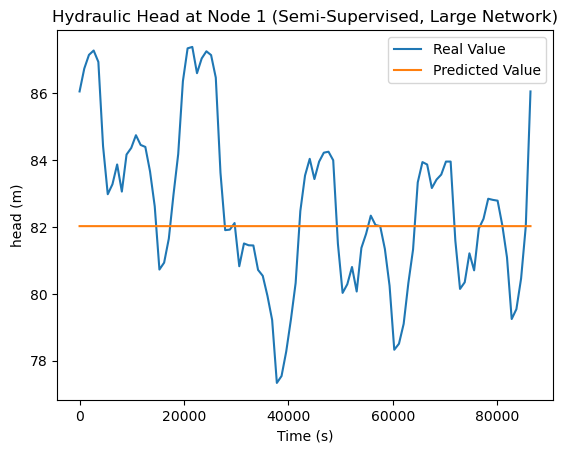

In [55]:
head_at_node514 = head.loc[:,'node_0001']
ax = head_at_node5.plot()
ax.set_xlabel("Time (s)")
ax.set_ylabel("head (m)")
Pre_ana = Pre_ana.set_index(head.index)

Pre_ana['Node 1'].plot(ax=ax)
plt.title('Hydraulic Head at Node 1 (Semi-Supervised, Large Network)')
plt.legend(['Real Value', 'Predicted Value'])
plt.savefig('Hydraulic Head at Node 1 (Semi-Supervised, Large Network).png')
plt.show()

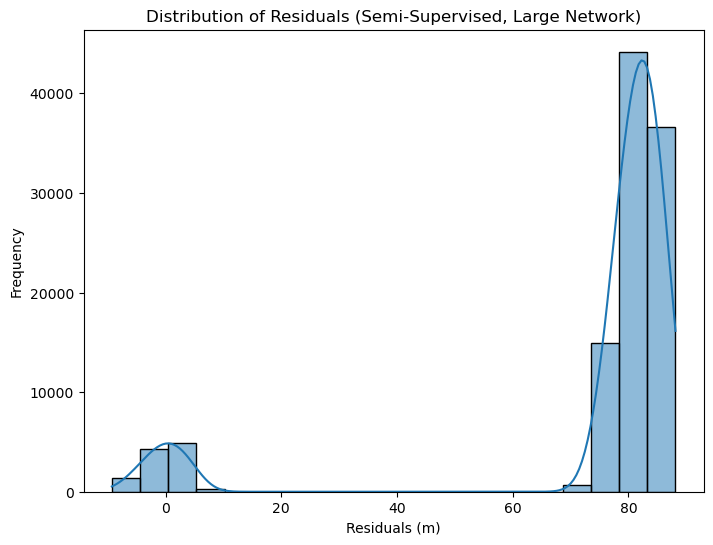

In [53]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.histplot(residuals, kde=True, bins=20)  # kde=True adds a Kernel Density Estimation curve
plt.xlabel('Residuals (m)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.title('Distribution of Residuals (Semi-Supervised, Large Network)')
plt.savefig('Distribution of Residuals (Semi-Supervised, Large Network).png')
plt.show()

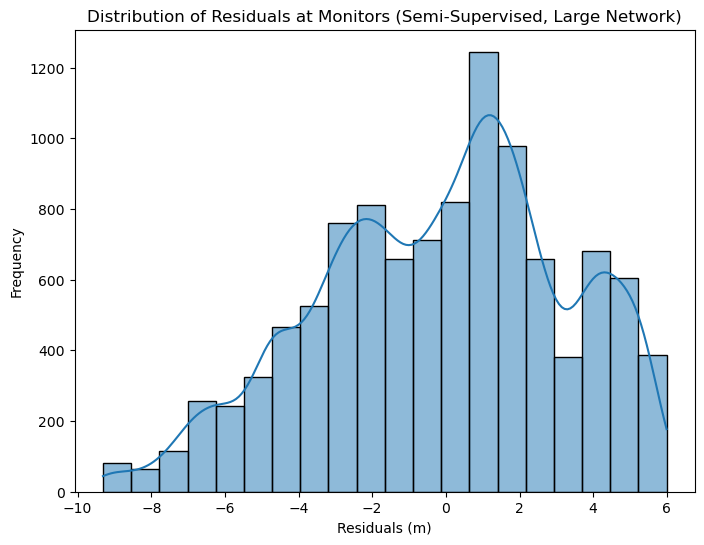

In [54]:
RESI = ana[ana['node'].isin(monitor)]['residuals']
Other_RESI = ana[~ana['node'].isin(monitor)]['residuals']
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.histplot(RESI, kde=True, bins=20)  # kde=True adds a Kernel Density Estimation curve
plt.xlabel('Residuals (m)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals at Monitors (Semi-Supervised, Large Network)')

plt.savefig('Distribution of Residuals at Monitors (Semi-Supervised, Large Network).png')
plt.show()

In [48]:
residuals.max()

88.13980969786644

In [49]:
residuals.min()

-9.311424255371094

In [50]:
RESI.max()

5.99200439453125

In [51]:
RESI.min()

-9.311424255371094